In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader # loads data in batches
from torchvision import datasets # load MNIST
import torchvision.transforms as T # transformers for computer vision
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

In [2]:
synapse_weight = np.load('Synapse_weight/weight1_3period_range20.npy')

print(np.min(synapse_weight), np.max(synapse_weight))
print(len(synapse_weight))

-20.0 20.0
150


# Data processing

In [3]:
totensor = T.ToTensor() # image (3D array) to Tensor

train_data = datasets.MNIST(root = './', download=False, train = True, transform = totensor)
test_data = datasets.MNIST(root = './', download=False, train = False, transform = totensor)

In [4]:
img, label = train_data[0]
print(img.shape) # returns a Tensor of Size 1,28,28
print(type(label))

torch.Size([1, 28, 28])
<class 'int'>


In [5]:
import torch.nn.functional as F
# 只取 0, 1, 2 作為資料集
# print(len(train_data))
# new_train_img = []
# new_train_label = []
# for i in range(len(train_data)):
#     img, label = train_data[i]
#     if label == 0 or label == 1 or label == 2:
#         new_train_img.append(img.numpy())
#         new_train_label.append(label)
# print(len(new_train_img))

# print(len(test_data))
# new_test_img = []
# new_test_label = []
# for i in range(len(test_data)):
#     img, label = test_data[i]
#     if label == 0 or label == 1 or label == 2:
#         new_test_img.append(img.numpy())
#         new_test_label.append(label)
        
# print(len(new_test_img))

# 取出label為3, 6, 8的資料
new_train_img = []
new_train_label = []
selected_labels = [3, 6, 8]
for i in range(len(train_data)):
    _, label = train_data[i]
    if label in selected_labels:
        one_hot_label = torch.tensor([int(label == selected_labels[0]), int(label == selected_labels[1]), int(label == selected_labels[2])]).float()
        new_train_img.append(train_data[i][0].numpy())
        new_train_label.append(one_hot_label)
print(len(new_train_img))

new_test_img = []
new_test_label = []
for i in range(len(test_data)):
    _, label = test_data[i]
    if label in selected_labels:
        one_hot_label = torch.tensor([int(label == selected_labels[0]), int(label == selected_labels[1]), int(label == selected_labels[2])]).float()
        new_test_img.append(test_data[i][0].numpy())
        new_test_label.append(one_hot_label)
print(len(new_test_img))

17900
2942


In [6]:
new_train_img, new_train_label = np.array(new_train_img), np.array(new_train_label)
new_test_img, new_test_label = np.array(new_test_img), np.array(new_test_label)
print(new_train_img.shape, new_train_label.shape)
print(new_test_img.shape, new_test_label.shape)

(17900, 1, 28, 28) (17900,)
(2942, 1, 28, 28) (2942,)


C:\Users\User\AppData\Local\Temp\ipykernel_24032\655990533.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  new_train_img, new_train_label = np.array(new_train_img), np.array(new_train_label)
C:\Users\User\AppData\Local\Temp\ipykernel_24032\655990533.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_train_img, new_train_label = np.array(new_train_img), np.a

In [7]:
# plt.imshow(new_train_img[0].reshape(28,28), cmap = 'gist_yarg'); # gist_yarg plots inverse of W&B

In [8]:
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass

class MNIST_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).type(torch.FloatTensor)
        # self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.y = y
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

torch.manual_seed(101)

train_loader = DataLoader(MNIST_Dataset(new_train_img, new_train_label), batch_size=100, shuffle=True)
test_loader =  DataLoader(MNIST_Dataset(new_test_img, new_test_label),  batch_size=500, shuffle=False)

@dataclass
class Loader:
    """
    Custom class to accomodate train and test loader iterators
    If we run one iteration now, we will have one batch of the training dataset
    """
    train: DataLoader
    test: DataLoader

mnist_loader = Loader(train_loader, test_loader)
for img, label in mnist_loader.train:
    break # we run only one iteration , after that we break
print(img.shape) # bz, ch, W H
print(mnist_loader.train)

torch.Size([100, 1, 28, 28])


# Build model

In [9]:
class ThreeLayerANN(nn.Module):
    
    def __init__(self, in_size = 784, out_size=3):
        """
        * 784 input layers 
        * 2 hiden layers of 3 and 3 neurons respectively
        * 3 output layer
        """
        super(ThreeLayerANN, self).__init__()
        
        self.layer1 = nn.Linear(in_size, 3)
        self.layer2 = nn.Linear(3, 3)
        self.layer3 = nn.Linear(3, out_size)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim = 1)

        # weights initialize
        self.layer1.weight.data.normal_(mean=0.0, std=1.0)
        self.layer1.bias.data.zero_()
        self.layer2.weight.data.normal_(mean=0.0, std=1.0)
        self.layer2.bias.data.zero_()
        self.layer3.weight.data.normal_(mean=0.0, std=1.0)
        self.layer3.bias.data.zero_()
            
    def forward(self, X):

        X = self.sigmoid(self.layer1(X))
        X = self.sigmoid(self.layer2(X))
        X = self.layer3(X)
        
        return self.softmax(X) # multi-class classification, the sum of all probabilities is 1

model = ThreeLayerANN().cuda()
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 3]           2,355
           Sigmoid-2                 [-1, 1, 3]               0
            Linear-3                 [-1, 1, 3]              12
           Sigmoid-4                 [-1, 1, 3]               0
            Linear-5                 [-1, 1, 3]              12
           Softmax-6                 [-1, 1, 3]               0
Total params: 2,379
Trainable params: 2,379
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


# Train

In [10]:
def train_model(model, loader, criterion, optimizer, scheduler, epochs=50, synapse=False, weight_file='', w_range=(-2, 2)):
    """
    synapse : bool, default=False. 若synapse=True則限制權重於給定的檔案
    """
    selected_labels = [3, 6, 8]
    if synapse:
        synapse_weight = np.load(weight_file)
    Loss = {'train':[], 'test':[]}
    Accuracy = {'train':[], 'test':[]}
    model = model.cuda()

    for epoch in tqdm(range(epochs)):
        # we set the number of True positives to zero in every epoch
        train_corr = 0
        test_corr = 0
        train_size = 0
        test_size = 0
        
        ##### Training loop #####
        model.train()
        for batch, (img, label) in enumerate(loader.train): 
            batch +=1
            train_size += len(img)
            img = img.cuda()
            label = label.cuda()
            y_pred = model(img.view(img.shape[0],-1)) # batch size for train is 100
            loss = criterion(y_pred, label)
            
            # last 3-layer neurons into one result
            preds_classes = torch.argmax(y_pred, dim=1)
            targets_classes = torch.argmax(label, dim=1)
            prediction = torch.max(y_pred, dim=1) # return (values, indices)
            train_corr += torch.sum(preds_classes == targets_classes).item() # sum of correct predictions

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            ##### 限制權重範圍 #####
            for p in model.parameters():
                p.data.clamp_(w_range[0], w_range[1])
            #######################
            
            if synapse:
                ##### 限制權重的值 #####
                with torch.no_grad():
                    for i, param in enumerate(model.parameters()):
                        param_shape = param.shape
                        param_clone = torch.clone(param).cpu()
                        w_index = np.argmin(np.abs(param_clone.numpy().reshape(-1, 1) - np.tile(np.array(synapse_weight).reshape(1, -1), (param_clone.numpy().size, 1))), axis=1)
                        param[...] = torch.Tensor(synapse_weight[w_index]).view(param_shape)
                #######################
                
        scheduler.step()
        
        accuracy = 100 * (train_corr / train_size ) 
        print( f'Epoch:{epoch+1:2d} Train Loss: {loss.item():4.4f} Train Accuracy: {accuracy:4.4f} %' )

        Loss['train'].append(loss.item()) # store loss at the end of epoch
        Accuracy['train'].append(accuracy) # store accuracy at the end of epoch

        ##### Validation loop #####
        model.eval()
        # validation (test). Here we run batches of 500 images, the test loader runs 120 times (120 x 500 = 60,000)
        with torch.no_grad():
            for batch, (img, label) in enumerate(loader.test):
                batch +=1
                test_size += len(img)
                img = img.cuda()
                label = label.cuda()
                y_val = model(img.view(img.shape[0],-1)) # batch size for test is 500
                _, predicted = torch.max(y_val, dim = 1)
                preds_classes = torch.argmax(y_val, dim=1)
                targets_classes = torch.argmax(label, dim=1)
                test_corr += torch.sum(preds_classes == targets_classes).item()
        
        loss = criterion(y_val, label)
        Loss['test'].append(loss.item()) 
        accuracy = 100 * (test_corr / test_size)
        print( f'Test Accuracy: {accuracy:4.4f} %' )
        Accuracy['test'].append(accuracy)
    
    return model, Loss, Accuracy

# Case0

In [11]:
# case0 training (all ideal)
model_case0 = ThreeLayerANN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_case0.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
model0, Loss0, Accuracy0 = train_model(model=model_case0, loader=mnist_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=30, synapse=False, w_range=(-100, 100))

best_acc = np.max(Accuracy0['test'])
best_loss = np.min(Loss0['test'])
print('----------------------------------------------------')
print(f'Best Test Accuracy: {best_acc:4.4f} %')
print(f'Best Loss: {best_loss:.4f}')

  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]

Epoch: 1 Train Loss: 0.6820 Train Accuracy: 77.8492 %
Test Accuracy: 91.6044 %


  7%|▋         | 2/30 [00:01<00:24,  1.14it/s]

Epoch: 2 Train Loss: 0.6225 Train Accuracy: 92.8101 %
Test Accuracy: 92.2162 %


 10%|█         | 3/30 [00:02<00:21,  1.24it/s]

Epoch: 3 Train Loss: 0.6417 Train Accuracy: 93.8939 %
Test Accuracy: 93.1679 %


 13%|█▎        | 4/30 [00:03<00:21,  1.19it/s]

Epoch: 4 Train Loss: 0.7014 Train Accuracy: 92.3520 %
Test Accuracy: 88.9191 %


 17%|█▋        | 5/30 [00:04<00:22,  1.09it/s]

Epoch: 5 Train Loss: 0.6216 Train Accuracy: 93.3296 %
Test Accuracy: 95.7172 %


 20%|██        | 6/30 [00:05<00:21,  1.11it/s]

Epoch: 6 Train Loss: 0.5816 Train Accuracy: 95.5810 %
Test Accuracy: 95.8532 %


 23%|██▎       | 7/30 [00:06<00:19,  1.21it/s]

Epoch: 7 Train Loss: 0.5700 Train Accuracy: 95.7821 %
Test Accuracy: 95.6152 %


 27%|██▋       | 8/30 [00:06<00:16,  1.31it/s]

Epoch: 8 Train Loss: 0.5716 Train Accuracy: 95.9609 %
Test Accuracy: 96.0911 %


 30%|███       | 9/30 [00:07<00:15,  1.38it/s]

Epoch: 9 Train Loss: 0.6116 Train Accuracy: 96.0950 %
Test Accuracy: 96.0911 %


 33%|███▎      | 10/30 [00:07<00:14,  1.40it/s]

Epoch:10 Train Loss: 0.5816 Train Accuracy: 96.1955 %
Test Accuracy: 96.2610 %


 37%|███▋      | 11/30 [00:08<00:13,  1.46it/s]

Epoch:11 Train Loss: 0.5915 Train Accuracy: 96.2793 %
Test Accuracy: 96.0911 %


 40%|████      | 12/30 [00:09<00:11,  1.51it/s]

Epoch:12 Train Loss: 0.5916 Train Accuracy: 96.3240 %
Test Accuracy: 96.0911 %


 43%|████▎     | 13/30 [00:09<00:10,  1.55it/s]

Epoch:13 Train Loss: 0.5716 Train Accuracy: 96.3296 %
Test Accuracy: 96.1931 %


 47%|████▋     | 14/30 [00:10<00:10,  1.53it/s]

Epoch:14 Train Loss: 0.5916 Train Accuracy: 96.3464 %
Test Accuracy: 96.1591 %


 50%|█████     | 15/30 [00:11<00:10,  1.49it/s]

Epoch:15 Train Loss: 0.5916 Train Accuracy: 96.3575 %
Test Accuracy: 96.1591 %


 53%|█████▎    | 16/30 [00:11<00:10,  1.40it/s]

Epoch:16 Train Loss: 0.5917 Train Accuracy: 96.3631 %
Test Accuracy: 96.1591 %


 57%|█████▋    | 17/30 [00:12<00:09,  1.41it/s]

Epoch:17 Train Loss: 0.5816 Train Accuracy: 96.3631 %
Test Accuracy: 96.1591 %


 60%|██████    | 18/30 [00:13<00:08,  1.37it/s]

Epoch:18 Train Loss: 0.5916 Train Accuracy: 96.3631 %
Test Accuracy: 96.1591 %


 63%|██████▎   | 19/30 [00:14<00:08,  1.34it/s]

Epoch:19 Train Loss: 0.5616 Train Accuracy: 96.3631 %
Test Accuracy: 96.1591 %


 67%|██████▋   | 20/30 [00:15<00:07,  1.34it/s]

Epoch:20 Train Loss: 0.5816 Train Accuracy: 96.3687 %
Test Accuracy: 96.1591 %


 70%|███████   | 21/30 [00:15<00:06,  1.29it/s]

Epoch:21 Train Loss: 0.5716 Train Accuracy: 96.3687 %
Test Accuracy: 96.1591 %


 73%|███████▎  | 22/30 [00:16<00:06,  1.30it/s]

Epoch:22 Train Loss: 0.5816 Train Accuracy: 96.3687 %
Test Accuracy: 96.1591 %


 77%|███████▋  | 23/30 [00:17<00:05,  1.30it/s]

Epoch:23 Train Loss: 0.5916 Train Accuracy: 96.3687 %
Test Accuracy: 96.1591 %


 80%|████████  | 24/30 [00:18<00:04,  1.31it/s]

Epoch:24 Train Loss: 0.5717 Train Accuracy: 96.3687 %
Test Accuracy: 96.1591 %


 83%|████████▎ | 25/30 [00:18<00:03,  1.31it/s]

Epoch:25 Train Loss: 0.6015 Train Accuracy: 96.3743 %
Test Accuracy: 96.1591 %


 87%|████████▋ | 26/30 [00:19<00:03,  1.26it/s]

Epoch:26 Train Loss: 0.6013 Train Accuracy: 96.3743 %
Test Accuracy: 96.1591 %


 90%|█████████ | 27/30 [00:20<00:02,  1.27it/s]

Epoch:27 Train Loss: 0.5917 Train Accuracy: 96.3743 %
Test Accuracy: 96.1591 %


 93%|█████████▎| 28/30 [00:21<00:01,  1.28it/s]

Epoch:28 Train Loss: 0.5616 Train Accuracy: 96.3743 %
Test Accuracy: 96.1591 %


 97%|█████████▋| 29/30 [00:22<00:00,  1.25it/s]

Epoch:29 Train Loss: 0.5816 Train Accuracy: 96.3743 %
Test Accuracy: 96.1591 %


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]

Epoch:30 Train Loss: 0.6216 Train Accuracy: 96.3743 %
Test Accuracy: 96.1591 %
----------------------------------------------------
Best Test Accuracy: 96.2610 %
Best Loss: 0.5657


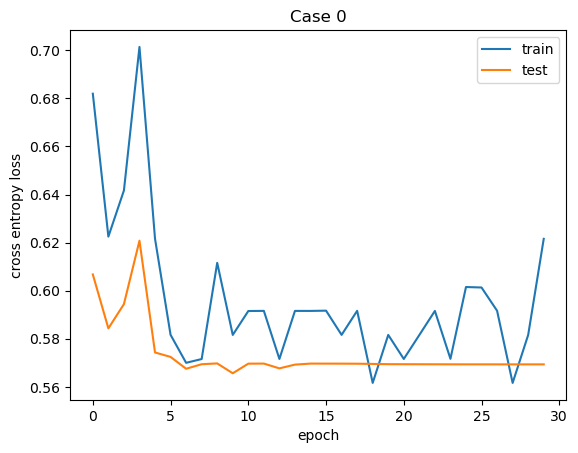

In [12]:
plt.figure()
plt.plot(Loss0['train'], label='train')
plt.plot(Loss0['test'], label='test')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Case 0')
plt.legend()
plt.show()

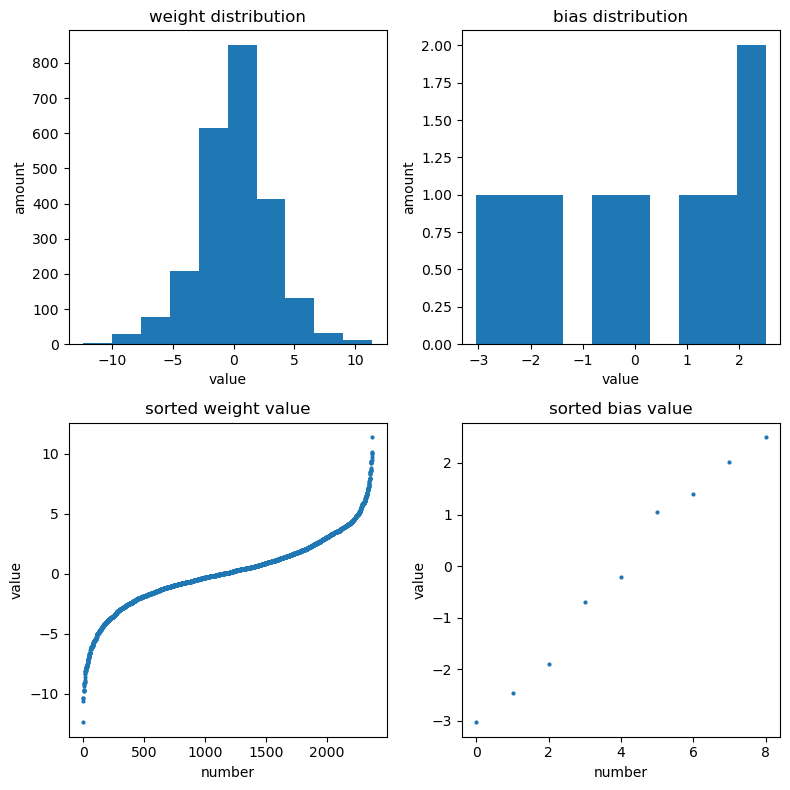

In [13]:
l1_w = model0.layer1.weight.data.clone().detach().cpu().numpy().ravel()
l1_b = model0.layer1.bias.data.clone().detach().cpu().numpy().ravel()
l2_w = model0.layer2.weight.data.clone().detach().cpu().numpy().ravel()
l2_b = model0.layer2.bias.data.clone().detach().cpu().numpy().ravel()
l3_w = model0.layer3.weight.data.clone().detach().cpu().numpy().ravel()
l3_b = model0.layer3.bias.data.clone().detach().cpu().numpy().ravel()
all_w = np.concatenate((l1_w, l2_w, l3_w), axis=0)
all_b = np.concatenate((l1_b, l2_b, l3_b), axis=0)

plt.figure(figsize=(8, 8))
ax = plt.subplot(221)
ax.set_title('weight distribution')
ax.set_xlabel('value')
ax.set_ylabel('amount')
plt.hist(all_w)

ax = plt.subplot(222)
ax.set_title('bias distribution')
ax.set_xlabel('value')
ax.set_ylabel('amount')
plt.hist(all_b)

ax = plt.subplot(223)
ax.set_title('sorted weight value')
ax.set_ylabel('value')
ax.set_xlabel('number')
plt.plot(np.sort(all_w), 'o', markersize=2)

ax = plt.subplot(224)
ax.set_title('sorted bias value')
ax.set_ylabel('value')
ax.set_xlabel('number')
plt.plot(np.sort(all_b), 'o', markersize=2)

plt.tight_layout()
plt.show()

# Case2 (fake weights)

In [14]:
# case2 training (ideal activation function / extracted synapse weight)
# using test weights ranging from (-2, 2) with 160 points uniform distributed
# model_case2_t = ThreeLayerANN()
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_case2_t.parameters(), lr=0.1)
# scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-7)
# model2_t, Loss2_t, Accuracy2_t = train_model(model=model_case2_t, loader=mnist_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=100, synapse=True, weight_file='./Synapse_weight/test_weight_160.npy', w_range=(-2, 2))

# best_acc = np.max(Accuracy2_t['test'])
# print('----------------------------------------------------')
# print(f'Best Test Accuracy: {best_acc:4.4f} %')

In [15]:
# plt.figure()
# plt.plot(Loss2_t['train'], label='train')
# plt.plot(Loss2_t['test'], label='test')
# plt.legend()
# plt.show()

In [16]:
# l1_w = model2_t.layer1.weight.data.clone().detach().cpu().numpy().ravel()
# l1_b = model2_t.layer1.bias.data.clone().detach().cpu().numpy().ravel()
# l2_w = model2_t.layer2.weight.data.clone().detach().cpu().numpy().ravel()
# l2_b = model2_t.layer2.bias.data.clone().detach().cpu().numpy().ravel()
# l3_w = model2_t.layer3.weight.data.clone().detach().cpu().numpy().ravel()
# l3_b = model2_t.layer3.bias.data.clone().detach().cpu().numpy().ravel()
# all_w = np.concatenate((l1_w, l2_w, l3_w), axis=0)
# all_b = np.concatenate((l1_b, l2_b, l3_b), axis=0)

# plt.figure(figsize=(10, 10))
# ax = plt.subplot(221)
# ax.set_title('weight distribution')
# plt.hist(all_w)

# ax = plt.subplot(222)
# ax.set_title('bias distribution')
# plt.hist(all_b)

# ax = plt.subplot(223)
# ax.set_title('sorted weight value')
# plt.plot(np.sort(all_w), 'o', markersize=2)

# ax = plt.subplot(224)
# ax.set_title('sorted bias value')
# plt.plot(np.sort(all_b), 'o', markersize=2)

# plt.show()

In [17]:
# 檢查權重是否有成功被限制
def is_subset(array1, array2):
    """
    判斷array1是否為array2的子集
    """
    set1 = set(array1)
    set2 = set(array2)
    return set1.issubset(set2)

# np.set_printoptions(threshold=np.inf)

# synapse_weight = np.load('Synapse_weight/test_weight_160.npy').astype(float).round(4)
# layer1_weight = model2_t.layer1.weight.data.detach().clone().cpu().numpy().reshape(-1).astype(float).round(4)
# layer1_bias = model2_t.layer1.bias.data.detach().clone().cpu().numpy().reshape(-1).astype(float).round(4)
# # print(synapse_weight.round(4).astype(float))
# # print(layer1_weight.round(4).astype(float))

# print(is_subset(layer1_weight, synapse_weight))
# print(is_subset(layer1_bias, synapse_weight))
# # print(np.isin(layer1_weight, synapse_weight))

# Case2 (Our 3 period data)

In [18]:
# case2 training (ideal activation function / extracted synapse weight)
# training with our weights
model_case2 = ThreeLayerANN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_case2.parameters(), lr=1e-1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
model2, Loss2, Accuracy2 = train_model(model=model_case2, loader=mnist_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=30, synapse=True, weight_file='./Synapse_weight/weight1_3period_range6.npy', w_range=(-6, 6))

best_acc = np.max(Accuracy2['test'])
best_loss = np.min(Loss2['test'])
print('----------------------------------------------------')
print(f'Best Test Accuracy: {best_acc:4.4f} %')
print(f'Best Loss: {best_loss:.4f}')

  3%|▎         | 1/30 [00:02<00:59,  2.06s/it]

Epoch: 1 Train Loss: 0.7775 Train Accuracy: 85.5363 %
Test Accuracy: 91.6723 %


  7%|▋         | 2/30 [00:04<00:57,  2.07s/it]

Epoch: 2 Train Loss: 0.7877 Train Accuracy: 91.5698 %
Test Accuracy: 92.0802 %


 10%|█         | 3/30 [00:06<00:54,  2.01s/it]

Epoch: 3 Train Loss: 0.7484 Train Accuracy: 92.1061 %
Test Accuracy: 92.8280 %


 13%|█▎        | 4/30 [00:08<00:53,  2.05s/it]

Epoch: 4 Train Loss: 0.7545 Train Accuracy: 92.7654 %
Test Accuracy: 93.0320 %


 17%|█▋        | 5/30 [00:10<00:50,  2.01s/it]

Epoch: 5 Train Loss: 0.7588 Train Accuracy: 92.9944 %
Test Accuracy: 93.3719 %


 20%|██        | 6/30 [00:12<00:48,  2.02s/it]

Epoch: 6 Train Loss: 0.7485 Train Accuracy: 93.2737 %
Test Accuracy: 93.3719 %


 23%|██▎       | 7/30 [00:14<00:46,  2.01s/it]

Epoch: 7 Train Loss: 0.7231 Train Accuracy: 93.2793 %
Test Accuracy: 93.3719 %


 27%|██▋       | 8/30 [00:16<00:44,  2.03s/it]

Epoch: 8 Train Loss: 0.7330 Train Accuracy: 93.2849 %
Test Accuracy: 93.3719 %


 30%|███       | 9/30 [00:18<00:42,  2.00s/it]

Epoch: 9 Train Loss: 0.7591 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 33%|███▎      | 10/30 [00:20<00:40,  2.02s/it]

Epoch:10 Train Loss: 0.7685 Train Accuracy: 93.2682 %
Test Accuracy: 93.3379 %


 37%|███▋      | 11/30 [00:22<00:38,  2.00s/it]

Epoch:11 Train Loss: 0.7722 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 40%|████      | 12/30 [00:24<00:36,  2.01s/it]

Epoch:12 Train Loss: 0.7724 Train Accuracy: 93.2682 %
Test Accuracy: 93.3379 %


 43%|████▎     | 13/30 [00:26<00:33,  1.99s/it]

Epoch:13 Train Loss: 0.7661 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 47%|████▋     | 14/30 [00:28<00:32,  2.01s/it]

Epoch:14 Train Loss: 0.7625 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 50%|█████     | 15/30 [00:30<00:29,  2.00s/it]

Epoch:15 Train Loss: 0.7378 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 53%|█████▎    | 16/30 [00:32<00:28,  2.01s/it]

Epoch:16 Train Loss: 0.7685 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 57%|█████▋    | 17/30 [00:34<00:26,  2.01s/it]

Epoch:17 Train Loss: 0.7488 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 60%|██████    | 18/30 [00:36<00:24,  2.02s/it]

Epoch:18 Train Loss: 0.7538 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 63%|██████▎   | 19/30 [00:38<00:22,  2.01s/it]

Epoch:19 Train Loss: 0.7396 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 67%|██████▋   | 20/30 [00:40<00:20,  2.03s/it]

Epoch:20 Train Loss: 0.7386 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 70%|███████   | 21/30 [00:42<00:18,  2.01s/it]

Epoch:21 Train Loss: 0.7422 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 73%|███████▎  | 22/30 [00:44<00:16,  2.02s/it]

Epoch:22 Train Loss: 0.7434 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 77%|███████▋  | 23/30 [00:46<00:13,  2.00s/it]

Epoch:23 Train Loss: 0.7483 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 80%|████████  | 24/30 [00:48<00:12,  2.01s/it]

Epoch:24 Train Loss: 0.7461 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 83%|████████▎ | 25/30 [00:50<00:10,  2.01s/it]

Epoch:25 Train Loss: 0.7514 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 87%|████████▋ | 26/30 [00:52<00:08,  2.02s/it]

Epoch:26 Train Loss: 0.7595 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 90%|█████████ | 27/30 [00:54<00:05,  1.99s/it]

Epoch:27 Train Loss: 0.7319 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 93%|█████████▎| 28/30 [00:56<00:04,  2.01s/it]

Epoch:28 Train Loss: 0.7528 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


 97%|█████████▋| 29/30 [00:58<00:01,  1.99s/it]

Epoch:29 Train Loss: 0.7540 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %


100%|██████████| 30/30 [01:00<00:00,  2.01s/it]

Epoch:30 Train Loss: 0.7506 Train Accuracy: 93.2737 %
Test Accuracy: 93.3379 %
----------------------------------------------------
Best Test Accuracy: 93.3719 %
Best Loss: 0.7366


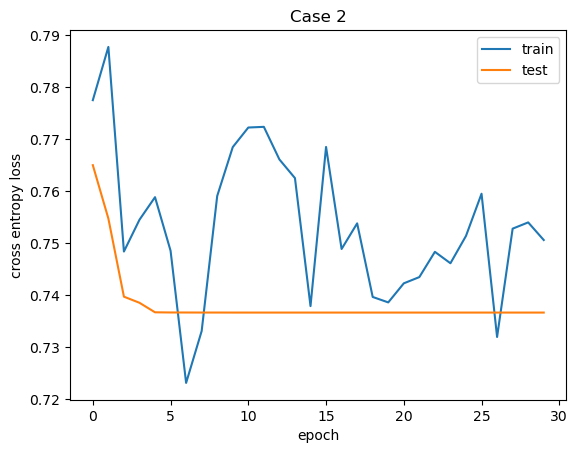

In [19]:
plt.figure()
plt.plot(Loss2['train'], label='train')
plt.plot(Loss2['test'], label='test')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Case 2')
plt.legend()
plt.show()

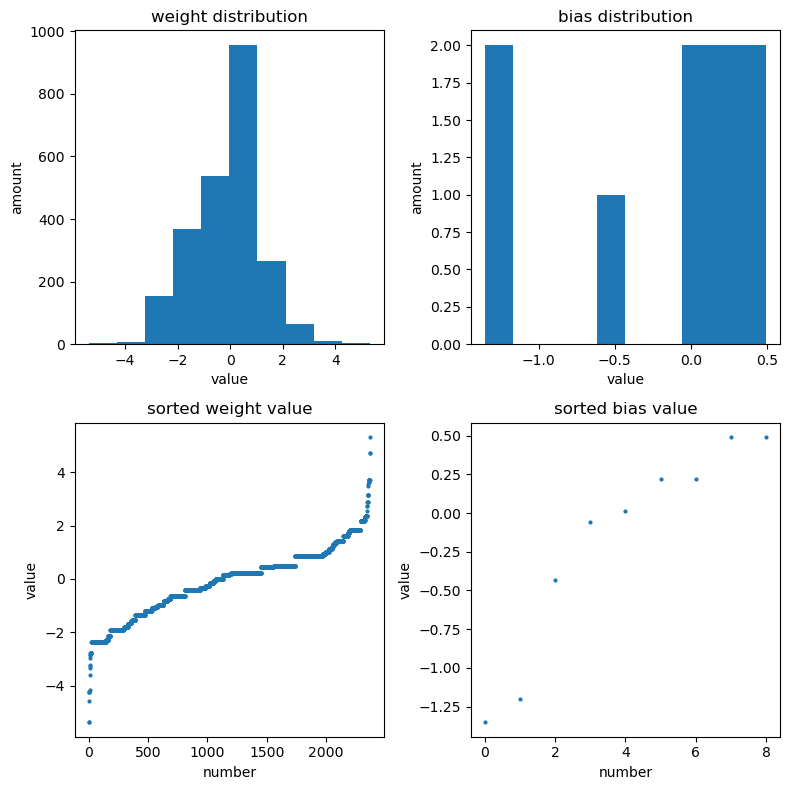

In [20]:
l1_w = model2.layer1.weight.data.clone().detach().cpu().numpy().ravel()
l1_b = model2.layer1.bias.data.clone().detach().cpu().numpy().ravel()
l2_w = model2.layer2.weight.data.clone().detach().cpu().numpy().ravel()
l2_b = model2.layer2.bias.data.clone().detach().cpu().numpy().ravel()
l3_w = model2.layer3.weight.data.clone().detach().cpu().numpy().ravel()
l3_b = model2.layer3.bias.data.clone().detach().cpu().numpy().ravel()
all_w = np.concatenate((l1_w, l2_w, l3_w), axis=0)
all_b = np.concatenate((l1_b, l2_b, l3_b), axis=0)

plt.figure(figsize=(8, 8))
ax = plt.subplot(221)
ax.set_title('weight distribution')
ax.set_xlabel('value')
ax.set_ylabel('amount')
plt.hist(all_w)

ax = plt.subplot(222)
ax.set_title('bias distribution')
ax.set_xlabel('value')
ax.set_ylabel('amount')
plt.hist(all_b)

ax = plt.subplot(223)
ax.set_title('sorted weight value')
ax.set_ylabel('value')
ax.set_xlabel('number')
plt.plot(np.sort(all_w), 'o', markersize=2)

ax = plt.subplot(224)
ax.set_title('sorted bias value')
ax.set_ylabel('value')
ax.set_xlabel('number')
plt.plot(np.sort(all_b), 'o', markersize=2)

plt.tight_layout()
plt.show()

In [21]:
synapse_weight = np.load('Synapse_weight/weight1_3period_range6.npy').astype(float).round(4)
layer1_weight = model2.layer1.weight.data.detach().clone().cpu().numpy().reshape(-1).astype(float).round(4)
layer1_bias = model2.layer1.bias.data.detach().clone().cpu().numpy().reshape(-1).astype(float).round(4)
# print(synapse_weight.round(4).astype(float))
# print(layer1_weight.round(4).astype(float))

print(is_subset(layer1_weight, synapse_weight))
print(is_subset(layer1_bias, synapse_weight))
# print(np.isin(layer1_weight, synapse_weight))

True
True


# Case2 (Our 1 period data)

In [22]:
# case2 training (ideal activation function / extracted synapse weight)
# training with our weights
model_case2_1p = ThreeLayerANN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_case2_1p.parameters(), lr=1e-1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
model2_1p, Loss2_1p, Accuracy2_1p = train_model(model=model_case2_1p, loader=mnist_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=30, synapse=True, weight_file='./Synapse_weight/weight1_1period.npy', w_range=(-2, 2))

best_acc = np.max(Accuracy2_1p['test'])
best_loss = np.min(Loss2_1p['test'])
print('----------------------------------------------------')
print(f'Best Test Accuracy: {best_acc:4.4f} %')
print(f'Best Loss: {best_loss:.4f}')

  3%|▎         | 1/30 [00:01<00:40,  1.40s/it]

Epoch: 1 Train Loss: 0.7959 Train Accuracy: 85.7654 %
Test Accuracy: 94.0177 %


  7%|▋         | 2/30 [00:02<00:40,  1.44s/it]

Epoch: 2 Train Loss: 0.7717 Train Accuracy: 94.2793 %
Test Accuracy: 94.6975 %


 10%|█         | 3/30 [00:04<00:38,  1.42s/it]

Epoch: 3 Train Loss: 0.7570 Train Accuracy: 94.7095 %
Test Accuracy: 94.7995 %


 13%|█▎        | 4/30 [00:05<00:37,  1.44s/it]

Epoch: 4 Train Loss: 0.7438 Train Accuracy: 94.9721 %
Test Accuracy: 95.0714 %


 17%|█▋        | 5/30 [00:07<00:36,  1.47s/it]

Epoch: 5 Train Loss: 0.7610 Train Accuracy: 95.2682 %
Test Accuracy: 95.3773 %


 20%|██        | 6/30 [00:08<00:34,  1.45s/it]

Epoch: 6 Train Loss: 0.7475 Train Accuracy: 95.5140 %
Test Accuracy: 95.3773 %


 23%|██▎       | 7/30 [00:10<00:33,  1.46s/it]

Epoch: 7 Train Loss: 0.7322 Train Accuracy: 95.5140 %
Test Accuracy: 95.3773 %


 27%|██▋       | 8/30 [00:11<00:31,  1.45s/it]

Epoch: 8 Train Loss: 0.7507 Train Accuracy: 95.5140 %
Test Accuracy: 95.3773 %


 30%|███       | 9/30 [00:13<00:30,  1.45s/it]

Epoch: 9 Train Loss: 0.7573 Train Accuracy: 95.5140 %
Test Accuracy: 95.3773 %


 33%|███▎      | 10/30 [00:14<00:29,  1.46s/it]

Epoch:10 Train Loss: 0.7582 Train Accuracy: 95.5028 %
Test Accuracy: 95.3773 %


 37%|███▋      | 11/30 [00:15<00:27,  1.45s/it]

Epoch:11 Train Loss: 0.7582 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 40%|████      | 12/30 [00:17<00:25,  1.43s/it]

Epoch:12 Train Loss: 0.7396 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 43%|████▎     | 13/30 [00:18<00:24,  1.42s/it]

Epoch:13 Train Loss: 0.7575 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 47%|████▋     | 14/30 [00:20<00:22,  1.43s/it]

Epoch:14 Train Loss: 0.7641 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 50%|█████     | 15/30 [00:21<00:21,  1.42s/it]

Epoch:15 Train Loss: 0.7546 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 53%|█████▎    | 16/30 [00:22<00:19,  1.42s/it]

Epoch:16 Train Loss: 0.7508 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 57%|█████▋    | 17/30 [00:24<00:18,  1.45s/it]

Epoch:17 Train Loss: 0.7595 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 60%|██████    | 18/30 [00:25<00:17,  1.44s/it]

Epoch:18 Train Loss: 0.7423 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 63%|██████▎   | 19/30 [00:27<00:15,  1.43s/it]

Epoch:19 Train Loss: 0.7360 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 67%|██████▋   | 20/30 [00:28<00:14,  1.44s/it]

Epoch:20 Train Loss: 0.7724 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 70%|███████   | 21/30 [00:30<00:12,  1.43s/it]

Epoch:21 Train Loss: 0.7450 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 73%|███████▎  | 22/30 [00:31<00:11,  1.43s/it]

Epoch:22 Train Loss: 0.7290 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 77%|███████▋  | 23/30 [00:33<00:10,  1.45s/it]

Epoch:23 Train Loss: 0.7407 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 80%|████████  | 24/30 [00:34<00:08,  1.47s/it]

Epoch:24 Train Loss: 0.7658 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 83%|████████▎ | 25/30 [00:36<00:07,  1.45s/it]

Epoch:25 Train Loss: 0.7377 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 87%|████████▋ | 26/30 [00:37<00:05,  1.43s/it]

Epoch:26 Train Loss: 0.7438 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 90%|█████████ | 27/30 [00:38<00:04,  1.42s/it]

Epoch:27 Train Loss: 0.7693 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 93%|█████████▎| 28/30 [00:40<00:02,  1.46s/it]

Epoch:28 Train Loss: 0.7577 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


 97%|█████████▋| 29/30 [00:41<00:01,  1.46s/it]

Epoch:29 Train Loss: 0.7575 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %


100%|██████████| 30/30 [00:43<00:00,  1.44s/it]

Epoch:30 Train Loss: 0.7356 Train Accuracy: 95.5084 %
Test Accuracy: 95.3773 %
----------------------------------------------------
Best Test Accuracy: 95.3773 %
Best Loss: 0.7401


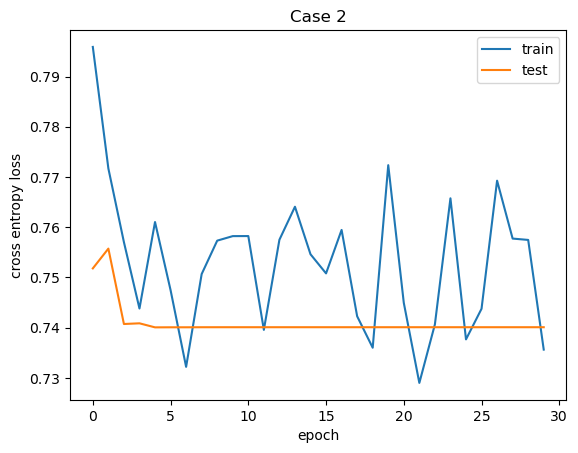

In [23]:
plt.figure()
plt.plot(Loss2_1p['train'], label='train')
plt.plot(Loss2_1p['test'], label='test')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Case 2')
plt.legend()
plt.show()

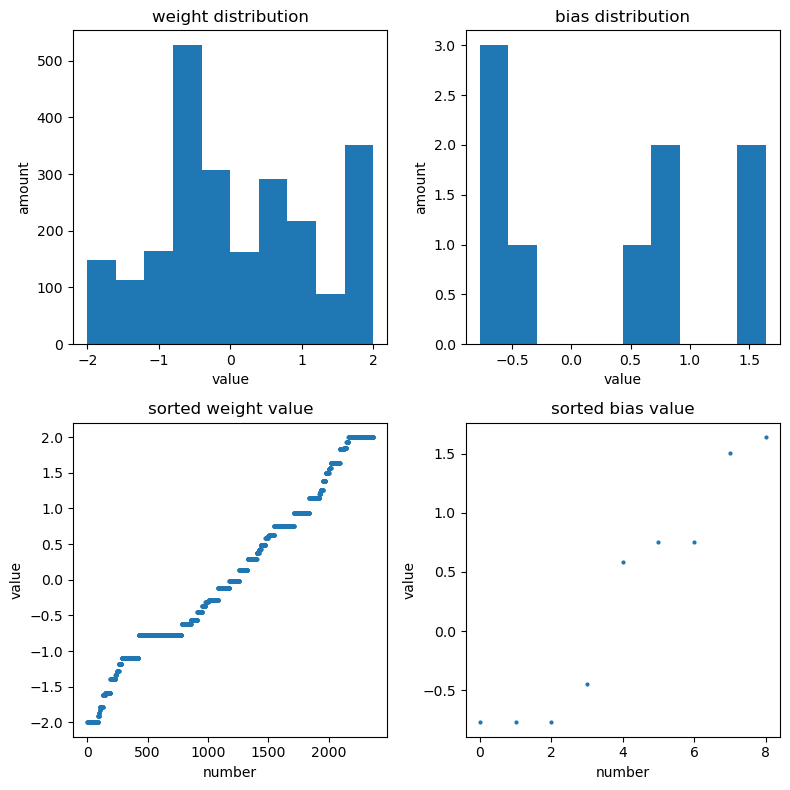

In [24]:
l1_w = model2_1p.layer1.weight.data.clone().detach().cpu().numpy().ravel()
l1_b = model2_1p.layer1.bias.data.clone().detach().cpu().numpy().ravel()
l2_w = model2_1p.layer2.weight.data.clone().detach().cpu().numpy().ravel()
l2_b = model2_1p.layer2.bias.data.clone().detach().cpu().numpy().ravel()
l3_w = model2_1p.layer3.weight.data.clone().detach().cpu().numpy().ravel()
l3_b = model2_1p.layer3.bias.data.clone().detach().cpu().numpy().ravel()
all_w = np.concatenate((l1_w, l2_w, l3_w), axis=0)
all_b = np.concatenate((l1_b, l2_b, l3_b), axis=0)

plt.figure(figsize=(8, 8))
ax = plt.subplot(221)
ax.set_title('weight distribution')
ax.set_xlabel('value')
ax.set_ylabel('amount')
plt.hist(all_w)

ax = plt.subplot(222)
ax.set_title('bias distribution')
ax.set_xlabel('value')
ax.set_ylabel('amount')
plt.hist(all_b)

ax = plt.subplot(223)
ax.set_title('sorted weight value')
ax.set_ylabel('value')
ax.set_xlabel('number')
plt.plot(np.sort(all_w), 'o', markersize=2)

ax = plt.subplot(224)
ax.set_title('sorted bias value')
ax.set_ylabel('value')
ax.set_xlabel('number')
plt.plot(np.sort(all_b), 'o', markersize=2)

plt.tight_layout()
plt.show()

In [25]:
synapse_weight = np.load('Synapse_weight/weight1_1period.npy').astype(float).round(4)
layer1_weight = model2_1p.layer1.weight.data.detach().clone().cpu().numpy().reshape(-1).astype(float).round(4)
layer1_bias = model2_1p.layer1.bias.data.detach().clone().cpu().numpy().reshape(-1).astype(float).round(4)
# print(synapse_weight.round(4).astype(float))
# print(layer1_weight.round(4).astype(float))

print(is_subset(layer1_weight, synapse_weight))
print(is_subset(layer1_bias, synapse_weight))
# print(np.isin(layer1_weight, synapse_weight))

True
True


# Case1

In [26]:
# define our fitted sigmoid function
class Fit_sigmoid(torch.nn.Module):
    def __init__(self):
        super(Fit_sigmoid, self).__init__()

    def forward(self, x):
        A1 = -0.0113177013264537
        A2 = 0.951482622149164
        x0 = -0.172518688334704
        dx = 0.531396293380814
        return (A1-A2) / (1+torch.exp((x-x0)/dx)) + A2 


#  restrict linear output in (-4, 4)
class ClampedLinear(nn.Module):
    def __init__(self, in_features, out_features, clamp_min, clamp_max):
        super(ClampedLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.clamp_min = clamp_min
        self.clamp_max = clamp_max

        # weight initialize
        self.linear.weight.data.normal_(mean=0.0, std=1.0)
        self.linear.bias.data.zero_()

    def forward(self, x):
        x = self.linear(x)
        x = torch.clamp(x, self.clamp_min, self.clamp_max)
        return x

    def weight(self):
        return self.linear.weight
    
    def bias(self):
        return self.linear.bias


# ANN using our sigmoid function
class ThreeLayerANN_FitSig(nn.Module):
    def __init__(self, in_size = 784, out_size=3):
        """
        * 784 input layers 
        * 2 hiden layers of 3 and 3 neurons respectively
        * 3 output layer
        """
        super(ThreeLayerANN_FitSig, self).__init__()
        
        self.layer1 = ClampedLinear(in_size, 3, clamp_min=-4, clamp_max=4)
        self.layer2 = ClampedLinear(3, 3, clamp_min=-4, clamp_max=4)
        self.layer3 = nn.Linear(3, out_size)
        self.sigmoid = Fit_sigmoid()
        self.softmax = nn.Softmax(dim = 1)

        # weights initialize
        self.layer3.weight.data.normal_(mean=0.0, std=1.0)
        self.layer3.bias.data.zero_()
            
    def forward(self, X):
        X = self.layer1(X)
        X = self.sigmoid(X)
        X = self.sigmoid(self.layer2(X))
        X = self.layer3(X)
        
        return self.softmax(X) # multi-class classification, the sum of all probabilities is 1

model = ThreeLayerANN_FitSig().cuda()
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 3]           2,355
     ClampedLinear-2                 [-1, 1, 3]               0
       Fit_sigmoid-3                 [-1, 1, 3]               0
            Linear-4                 [-1, 1, 3]              12
     ClampedLinear-5                 [-1, 1, 3]               0
       Fit_sigmoid-6                 [-1, 1, 3]               0
            Linear-7                 [-1, 1, 3]              12
           Softmax-8                 [-1, 1, 3]               0
Total params: 2,379
Trainable params: 2,379
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [27]:
# case0 training (all ideal)
model_case1 = ThreeLayerANN_FitSig()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_case1.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
model1, Loss1, Accuracy1 = train_model(model=model_case1, loader=mnist_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=30, synapse=False, w_range=(-100, 100))

best_acc = np.max(Accuracy1['test'])
best_loss = np.min(Loss1['test'])
print('----------------------------------------------------')
print(f'Best Test Accuracy: {best_acc:4.4f} %')
print(f'Best Loss: {best_loss:.4f}')

  3%|▎         | 1/30 [00:00<00:24,  1.20it/s]

Epoch: 1 Train Loss: 0.6331 Train Accuracy: 80.2570 %
Test Accuracy: 93.7797 %


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

Epoch: 2 Train Loss: 0.6320 Train Accuracy: 92.0782 %
Test Accuracy: 92.2502 %


 10%|█         | 3/30 [00:02<00:20,  1.32it/s]

Epoch: 3 Train Loss: 0.6814 Train Accuracy: 92.6145 %
Test Accuracy: 85.3161 %


 13%|█▎        | 4/30 [00:03<00:19,  1.33it/s]

Epoch: 4 Train Loss: 0.5917 Train Accuracy: 92.1061 %
Test Accuracy: 94.5955 %


 17%|█▋        | 5/30 [00:03<00:20,  1.25it/s]

Epoch: 5 Train Loss: 0.6316 Train Accuracy: 92.3184 %
Test Accuracy: 93.2019 %


 20%|██        | 6/30 [00:04<00:18,  1.27it/s]

Epoch: 6 Train Loss: 0.5716 Train Accuracy: 93.6536 %
Test Accuracy: 94.6635 %


 23%|██▎       | 7/30 [00:05<00:17,  1.29it/s]

Epoch: 7 Train Loss: 0.6116 Train Accuracy: 94.6760 %
Test Accuracy: 95.2073 %


 27%|██▋       | 8/30 [00:06<00:17,  1.28it/s]

Epoch: 8 Train Loss: 0.6416 Train Accuracy: 95.0168 %
Test Accuracy: 95.4793 %


 30%|███       | 9/30 [00:07<00:16,  1.27it/s]

Epoch: 9 Train Loss: 0.6016 Train Accuracy: 95.4749 %
Test Accuracy: 95.7172 %


 33%|███▎      | 10/30 [00:08<00:16,  1.19it/s]

Epoch:10 Train Loss: 0.6016 Train Accuracy: 95.5196 %
Test Accuracy: 95.4793 %


 37%|███▋      | 11/30 [00:08<00:16,  1.18it/s]

Epoch:11 Train Loss: 0.5916 Train Accuracy: 95.4078 %
Test Accuracy: 95.4793 %


 40%|████      | 12/30 [00:09<00:15,  1.17it/s]

Epoch:12 Train Loss: 0.6016 Train Accuracy: 95.4860 %
Test Accuracy: 95.5133 %


 43%|████▎     | 13/30 [00:10<00:14,  1.18it/s]

Epoch:13 Train Loss: 0.6016 Train Accuracy: 95.5642 %
Test Accuracy: 95.5472 %


 47%|████▋     | 14/30 [00:11<00:13,  1.14it/s]

Epoch:14 Train Loss: 0.5913 Train Accuracy: 95.6425 %
Test Accuracy: 95.5472 %


 50%|█████     | 15/30 [00:12<00:13,  1.14it/s]

Epoch:15 Train Loss: 0.6183 Train Accuracy: 95.6816 %
Test Accuracy: 95.6492 %


 53%|█████▎    | 16/30 [00:13<00:12,  1.15it/s]

Epoch:16 Train Loss: 0.5716 Train Accuracy: 95.7486 %
Test Accuracy: 95.6492 %


 57%|█████▋    | 17/30 [00:14<00:11,  1.16it/s]

Epoch:17 Train Loss: 0.5916 Train Accuracy: 95.7486 %
Test Accuracy: 95.6152 %


 60%|██████    | 18/30 [00:14<00:10,  1.16it/s]

Epoch:18 Train Loss: 0.5916 Train Accuracy: 95.7598 %
Test Accuracy: 95.6152 %


 63%|██████▎   | 19/30 [00:15<00:09,  1.13it/s]

Epoch:19 Train Loss: 0.6216 Train Accuracy: 95.7709 %
Test Accuracy: 95.6152 %


 67%|██████▋   | 20/30 [00:16<00:08,  1.14it/s]

Epoch:20 Train Loss: 0.6715 Train Accuracy: 95.7709 %
Test Accuracy: 95.6152 %


 70%|███████   | 21/30 [00:17<00:07,  1.15it/s]

Epoch:21 Train Loss: 0.6016 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %


 73%|███████▎  | 22/30 [00:18<00:06,  1.16it/s]

Epoch:22 Train Loss: 0.5916 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %


 77%|███████▋  | 23/30 [00:19<00:06,  1.11it/s]

Epoch:23 Train Loss: 0.5916 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %


 80%|████████  | 24/30 [00:20<00:05,  1.10it/s]

Epoch:24 Train Loss: 0.5916 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %


 83%|████████▎ | 25/30 [00:21<00:04,  1.12it/s]

Epoch:25 Train Loss: 0.6216 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %


 87%|████████▋ | 26/30 [00:22<00:03,  1.13it/s]

Epoch:26 Train Loss: 0.5921 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %


 90%|█████████ | 27/30 [00:22<00:02,  1.13it/s]

Epoch:27 Train Loss: 0.5616 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %


 93%|█████████▎| 28/30 [00:23<00:01,  1.10it/s]

Epoch:28 Train Loss: 0.6116 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %


 97%|█████████▋| 29/30 [00:24<00:00,  1.11it/s]

Epoch:29 Train Loss: 0.5816 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]

Epoch:30 Train Loss: 0.5816 Train Accuracy: 95.7765 %
Test Accuracy: 95.6152 %
----------------------------------------------------
Best Test Accuracy: 95.7172 %
Best Loss: 0.5719


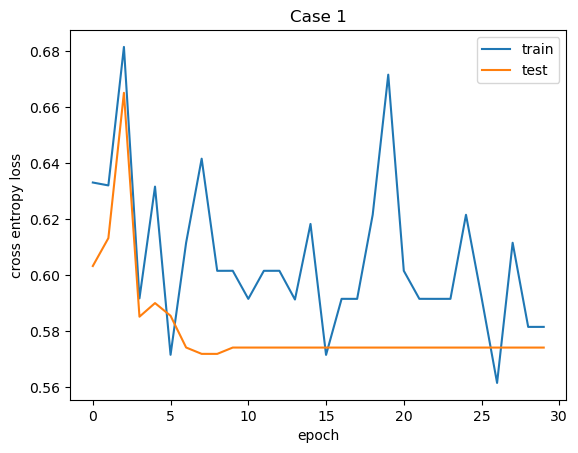

In [28]:
plt.figure()
plt.plot(Loss1['train'], label='train')
plt.plot(Loss1['test'], label='test')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Case 1')
plt.legend()
plt.show()

# Case 3

In [29]:
model_case3 = ThreeLayerANN_FitSig()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_case3.parameters(), lr=1e-1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
model3, Loss3, Accuracy3 = train_model(model=model_case3, loader=mnist_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=30, synapse=True, weight_file='./Synapse_weight/weight1_3period_range6.npy', w_range=(-6, 6))

best_acc = np.max(Accuracy3['test'])
best_loss = np.min(Loss3['test'])
print('----------------------------------------------------')
print(f'Best Test Accuracy: {best_acc:4.4f} %')
print(f'Best Loss: {best_loss:.4f}')

  3%|▎         | 1/30 [00:02<01:04,  2.24s/it]

Epoch: 1 Train Loss: 0.7072 Train Accuracy: 82.3687 %
Test Accuracy: 90.4827 %


  7%|▋         | 2/30 [00:04<01:00,  2.17s/it]

Epoch: 2 Train Loss: 0.7167 Train Accuracy: 91.0782 %
Test Accuracy: 91.7743 %


 10%|█         | 3/30 [00:06<00:58,  2.15s/it]

Epoch: 3 Train Loss: 0.7051 Train Accuracy: 92.0615 %
Test Accuracy: 92.7260 %


 13%|█▎        | 4/30 [00:08<00:54,  2.11s/it]

Epoch: 4 Train Loss: 0.7158 Train Accuracy: 92.4693 %
Test Accuracy: 91.8763 %


 17%|█▋        | 5/30 [00:10<00:53,  2.14s/it]

Epoch: 5 Train Loss: 0.6876 Train Accuracy: 92.7933 %
Test Accuracy: 93.0659 %


 20%|██        | 6/30 [00:12<00:51,  2.13s/it]

Epoch: 6 Train Loss: 0.7153 Train Accuracy: 93.2179 %
Test Accuracy: 93.2699 %


 23%|██▎       | 7/30 [00:14<00:49,  2.13s/it]

Epoch: 7 Train Loss: 0.6941 Train Accuracy: 93.2458 %
Test Accuracy: 93.2699 %


 27%|██▋       | 8/30 [00:17<00:46,  2.11s/it]

Epoch: 8 Train Loss: 0.7079 Train Accuracy: 93.2737 %
Test Accuracy: 93.2699 %


 30%|███       | 9/30 [00:19<00:44,  2.12s/it]

Epoch: 9 Train Loss: 0.6994 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 33%|███▎      | 10/30 [00:21<00:42,  2.12s/it]

Epoch:10 Train Loss: 0.6957 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 37%|███▋      | 11/30 [00:23<00:40,  2.12s/it]

Epoch:11 Train Loss: 0.7021 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 40%|████      | 12/30 [00:25<00:38,  2.14s/it]

Epoch:12 Train Loss: 0.6788 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 43%|████▎     | 13/30 [00:27<00:35,  2.12s/it]

Epoch:13 Train Loss: 0.6871 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 47%|████▋     | 14/30 [00:29<00:34,  2.13s/it]

Epoch:14 Train Loss: 0.6977 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 50%|█████     | 15/30 [00:31<00:31,  2.12s/it]

Epoch:15 Train Loss: 0.6860 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 53%|█████▎    | 16/30 [00:34<00:29,  2.13s/it]

Epoch:16 Train Loss: 0.6940 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 57%|█████▋    | 17/30 [00:36<00:27,  2.12s/it]

Epoch:17 Train Loss: 0.7253 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 60%|██████    | 18/30 [00:38<00:25,  2.14s/it]

Epoch:18 Train Loss: 0.7002 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 63%|██████▎   | 19/30 [00:40<00:23,  2.12s/it]

Epoch:19 Train Loss: 0.7074 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 67%|██████▋   | 20/30 [00:42<00:21,  2.16s/it]

Epoch:20 Train Loss: 0.7075 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 70%|███████   | 21/30 [00:44<00:19,  2.14s/it]

Epoch:21 Train Loss: 0.6982 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 73%|███████▎  | 22/30 [00:46<00:17,  2.13s/it]

Epoch:22 Train Loss: 0.7215 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 77%|███████▋  | 23/30 [00:48<00:14,  2.12s/it]

Epoch:23 Train Loss: 0.7004 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 80%|████████  | 24/30 [00:51<00:12,  2.14s/it]

Epoch:24 Train Loss: 0.6757 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 83%|████████▎ | 25/30 [00:53<00:10,  2.12s/it]

Epoch:25 Train Loss: 0.6841 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 87%|████████▋ | 26/30 [00:55<00:08,  2.12s/it]

Epoch:26 Train Loss: 0.7031 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 90%|█████████ | 27/30 [00:57<00:06,  2.12s/it]

Epoch:27 Train Loss: 0.6852 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 93%|█████████▎| 28/30 [00:59<00:04,  2.12s/it]

Epoch:28 Train Loss: 0.6678 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


 97%|█████████▋| 29/30 [01:01<00:02,  2.12s/it]

Epoch:29 Train Loss: 0.7057 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %


100%|██████████| 30/30 [01:03<00:00,  2.13s/it]

Epoch:30 Train Loss: 0.6907 Train Accuracy: 93.3017 %
Test Accuracy: 93.2699 %
----------------------------------------------------
Best Test Accuracy: 93.2699 %
Best Loss: 0.6696


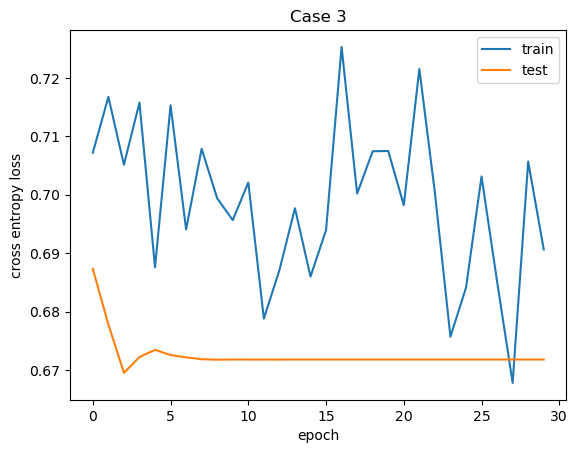

In [30]:
plt.figure()
plt.plot(Loss3['train'], label='train')
plt.plot(Loss3['test'], label='test')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Case 3')
plt.legend()
plt.show()

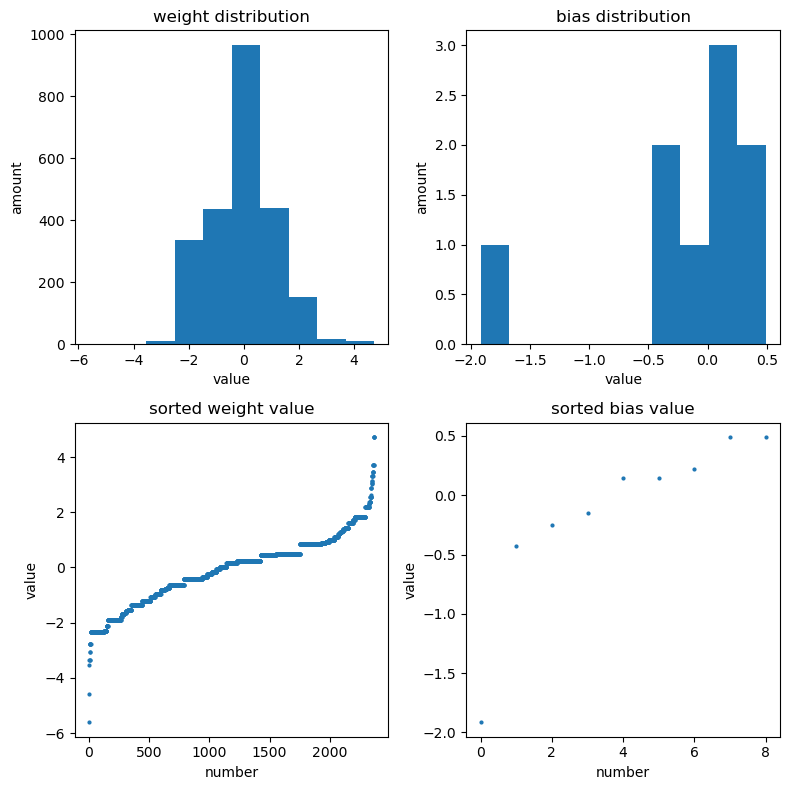

In [31]:
l1_w = model3.layer1.weight().data.clone().detach().cpu().numpy().ravel()
l1_b = model3.layer1.bias().data.clone().detach().cpu().numpy().ravel()
l2_w = model3.layer2.weight().data.clone().detach().cpu().numpy().ravel()
l2_b = model3.layer2.bias().data.clone().detach().cpu().numpy().ravel()
l3_w = model3.layer3.weight.data.clone().detach().cpu().numpy().ravel()
l3_b = model3.layer3.bias.data.clone().detach().cpu().numpy().ravel()
all_w = np.concatenate((l1_w, l2_w, l3_w), axis=0)
all_b = np.concatenate((l1_b, l2_b, l3_b), axis=0)

plt.figure(figsize=(8, 8))
ax = plt.subplot(221)
ax.set_title('weight distribution')
ax.set_xlabel('value')
ax.set_ylabel('amount')
plt.hist(all_w)

ax = plt.subplot(222)
ax.set_title('bias distribution')
ax.set_xlabel('value')
ax.set_ylabel('amount')
plt.hist(all_b)

ax = plt.subplot(223)
ax.set_title('sorted weight value')
ax.set_ylabel('value')
ax.set_xlabel('number')
plt.plot(np.sort(all_w), 'o', markersize=2)

ax = plt.subplot(224)
ax.set_title('sorted bias value')
ax.set_ylabel('value')
ax.set_xlabel('number')
plt.plot(np.sort(all_b), 'o', markersize=2)

plt.tight_layout()
plt.show()

In [33]:
synapse_weight = np.load('Synapse_weight/weight1_3period_range6.npy').astype(float).round(4)
layer1_weight = model3.layer1.weight().data.detach().clone().cpu().numpy().reshape(-1).astype(float).round(4)
layer1_bias = model3.layer1.bias().data.detach().clone().cpu().numpy().reshape(-1).astype(float).round(4)
# print(synapse_weight.round(4).astype(float))
# print(layer1_weight.round(4).astype(float))

print(is_subset(layer1_weight, synapse_weight))
print(is_subset(layer1_bias, synapse_weight))
# print(np.isin(layer1_weight, synapse_weight))

True
True


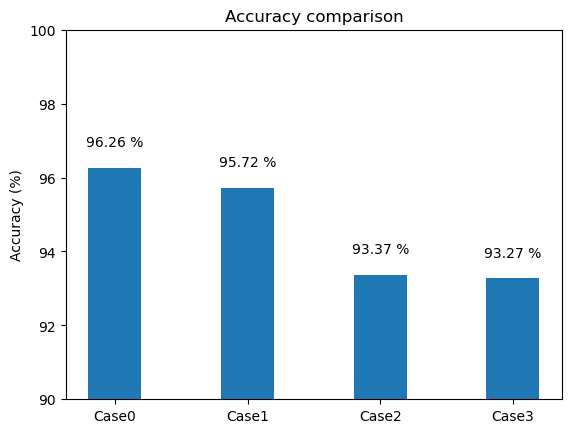

In [45]:
accs = [96.2610, 95.7172, 93.3719, 93.2699]
cases = ['Case0', 'Case1', 'Case2', 'Case3']

plt.figure()
plt.bar(cases, accs, width=0.4)
for a,b in zip(cases, accs):
    plt.text(a, b+0.5, '%.2f' % b+' %', ha='center', va= 'bottom',fontsize=10)
plt.title('Accuracy comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(90, 100)
plt.show()